<p style="text-align:center;">
<img src="https://resources.digitalfutures.com/data-science/datascience-notebook-header.png"
     alt="DigitalFuturesLogo"
     style="float: center; margin-right: 10px;" />
</p>

## Time Series
### Data


In [6]:
# to work with the dataset
import pandas as pd
import datetime
import numpy as np

# visualisation collection
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# to train/test split
from sklearn.model_selection import train_test_split

# to plot autocorrelation functions and seasonality test
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# for statistical analysis
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

# ARIMA and Seasonal ARIMA TimeSeries Modelling
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# for sentiment analysis
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 133kB 33.5MB/s 


In [7]:
## import files from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
### read in historical data from Yahoo!Finance
## timeframe: 17/09/2014 - 18/06/2021, daily frequency
btc = pd.read_csv('/content/drive/MyDrive/BTC-USD.csv')
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


## Data Dictionary 

* Open: The price at the opening of the market
* High: The highest price point of that day
* Low: The lowest price point of that day
* Close: The closing price at end of day when market closes 
* Adj Close: Typically this is close pricing but taking into account the major movements in the market
* Volume: Total trades that day


## EDA

In [9]:
## look at data types
btc.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [10]:
# check for nulls
btc.isnull().sum() # 5 nulls, we can drop them

Date         0
Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

In [11]:
# drop nulls
btc.dropna(inplace = True)

In [12]:
## overwrite Date column to pd datetime
btc['Date'] = pd.to_datetime(btc['Date'], format='%Y-%m-%d')
## set index of dataframe to be the date and sort by index
btc.set_index('Date', inplace=True)
btc.sort_index(inplace=True)

btc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [13]:
## filter df to specific year
btc.loc['2019']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09
...,...,...,...,...,...,...
2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,2.277736e+10
2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,2.136567e+10
2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832,7422.652832,2.244526e+10


In [16]:
# set daily frequency
btc = btc.asfreq('d')

In [17]:
# find avg value for each column by month
btc.resample('M').mean()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-30,412.654003,421.104422,398.174641,407.182428,407.182428,2.934864e+07
2014-10-31,365.748000,374.314260,354.856645,364.148873,364.148873,2.912885e+07
2014-11-30,364.850235,376.494235,357.241832,366.099799,366.099799,2.199111e+07
2014-12-31,343.074836,347.487129,336.565775,341.267871,341.267871,1.784201e+07
2015-01-31,251.799905,261.391583,240.495550,248.782547,248.782547,3.544555e+07
...,...,...,...,...,...,...
2021-02-28,45874.967216,47710.414621,44197.377302,46306.798968,46306.798968,8.096975e+10
2021-03-31,54544.678176,56250.979083,52964.134703,54998.008695,54998.008695,5.423175e+10
2021-04-30,57251.256250,58557.342057,55604.271094,57206.720052,57206.720052,6.148273e+10


In [18]:
# find avg value for each column by year
btc.resample('Y').mean()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,365.058217,373.265397,355.903726,363.693085,363.693085,2.383690e+07
2015-12-31,272.149011,278.151978,266.807891,272.453381,272.453381,3.390557e+07
2016-12-31,567.141429,574.302273,560.453374,568.492407,568.492407,8.592451e+07
2017-12-31,3970.644848,4144.687445,3811.707792,4006.033629,4006.033629,2.382867e+09
2018-12-31,7601.018680,7787.978969,7350.747939,7572.298947,7572.298947,6.063552e+09
2019-12-31,7385.218456,7549.907409,7222.602868,7395.246282,7395.246282,1.673049e+10
2020-12-31,11065.855235,11314.931724,10853.252084,11125.798836,11125.798836,3.195863e+10
2021-12-31,46774.693453,48333.404855,44917.742222,46813.275646,46813.275646,6.308860e+10


In [19]:
# look at mean and median of Open and Close for each year
btc[['Open', 'Close']].resample('Y').agg({'Open':['mean', 'median'], 'Close': ['mean', 'median']})

Open                       Close              
                    mean        median          mean        median
Date                                                              
2014-12-31    365.058217    365.272004    363.693085    364.145004
2015-12-31    272.149011    248.720993    272.453381    249.007004
2016-12-31    567.141429    582.071015    568.492407    582.555999
2017-12-31   3970.644848   2577.770020   4006.033629   2589.409912
2018-12-31   7601.018680   6919.979980   7572.298947   6906.919922
2019-12-31   7385.218456   7826.901367   7395.246282   7824.231445
2020-12-31  11065.855235   9689.468750  11125.798836   9695.278321
2021-12-31  46774.693453  48471.423828  46813.275646  48470.078125

In [20]:
# moving average
btc.rolling(3).mean()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,448.942332,450.956329,416.686005,425.523336,425.523336,3.115323e+07
2014-09-20,425.211995,435.996989,395.839671,409.379995,409.379995,3.642217e+07
2014-09-21,408.953664,421.185659,389.198670,400.840332,400.840332,3.378780e+07
...,...,...,...,...,...,...
2021-06-14,37304.300781,39236.690104,36116.528646,38289.617188,38289.617188,4.058075e+10
2021-06-15,38333.308594,40532.138021,37743.621094,39907.535156,39907.535156,4.341273e+10
2021-06-16,39870.942708,40930.136719,38847.596354,39657.269531,39657.269531,4.292690e+10


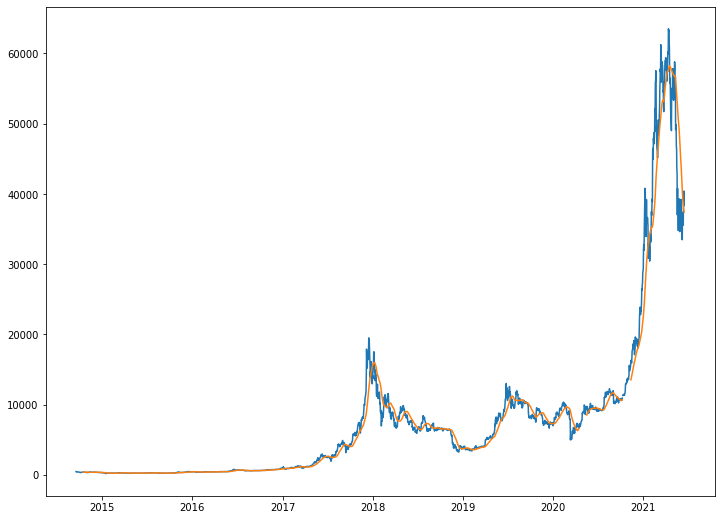

In [22]:
## Plot a line graph of the ## rolling to smoothe down spikes = extreme values
plt.figure(figsize=(12,9))
plt.plot(btc['Close'])
plt.plot(btc['Close'].rolling(30).mean())

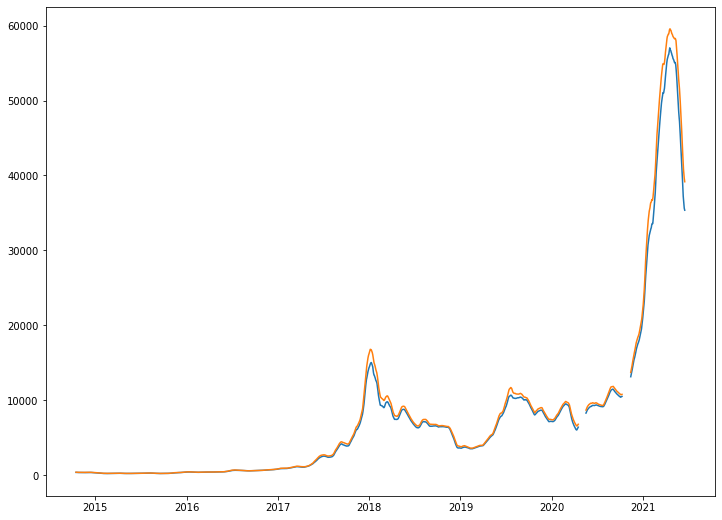

In [23]:
## Plot a line graph with both the Monthly Mean Low and Mean High for the year (two seperate lines)
plt.figure(figsize=(12,9))
plt.plot(btc['Low'].rolling(30).mean())
plt.plot(btc['High'].rolling(30).mean())

In [24]:
## difference between current value and previous value
btc.diff()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,-9.004029,-11.314026,-39.317993,-32.894013,-32.894013,1.342640e+07
2014-09-19,-32.756988,-29.024994,-28.571991,-29.644012,-29.644012,3.436500e+06
2014-09-20,-29.429993,-4.539001,5.350983,14.108002,14.108002,-1.056100e+06
2014-09-21,13.411987,-10.869995,3.298004,-10.082978,-10.082978,-1.028350e+07
...,...,...,...,...,...,...
2021-06-14,3461.179687,1655.582031,3893.175781,1120.617188,1120.617188,2.479802e+09
2021-06-15,1410.199219,316.906250,852.183594,187.792968,187.792968,3.271235e+09
2021-06-16,-258.476563,-778.492187,-1433.433594,-2059.207031,-2059.207031,-7.208514e+09


In [25]:
##
btc.pct_change()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,-0.019328,-0.024166,-0.086906,-0.071926,-0.071926,0.637628
2014-09-19,-0.071700,-0.063531,-0.069164,-0.069843,-0.069843,0.099657
2014-09-20,-0.069394,-0.010609,0.013916,0.035735,0.035735,-0.027851
2014-09-21,0.033983,-0.025679,0.008459,-0.024659,-0.024659,-0.278961
...,...,...,...,...,...,...
2021-06-14,0.097345,0.042102,0.111667,0.028662,0.028662,0.060975
2021-06-15,0.036143,0.007734,0.021988,0.004669,0.004669,0.075813
2021-06-16,-0.006394,-0.018852,-0.036189,-0.050963,-0.050963,-0.155288


In [26]:
# pct change per month
btc.resample('M').mean().pct_change()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-31,-0.113669,-0.111113,-0.108791,-0.105686,-0.105686,-0.007489
2014-11-30,-0.002455,0.005824,0.006722,0.005357,0.005357,-0.245040
2014-12-31,-0.059683,-0.077045,-0.057877,-0.067828,-0.067828,-0.188672
2015-01-31,-0.266050,-0.247766,-0.285443,-0.271005,-0.271005,0.986634
...,...,...,...,...,...,...
2021-02-28,0.323840,0.320042,0.351368,0.334372,0.334372,0.164273
2021-03-31,0.188986,0.179008,0.198355,0.187688,0.187688,-0.330222
2021-04-30,0.049621,0.041001,0.049848,0.040160,0.040160,0.133704


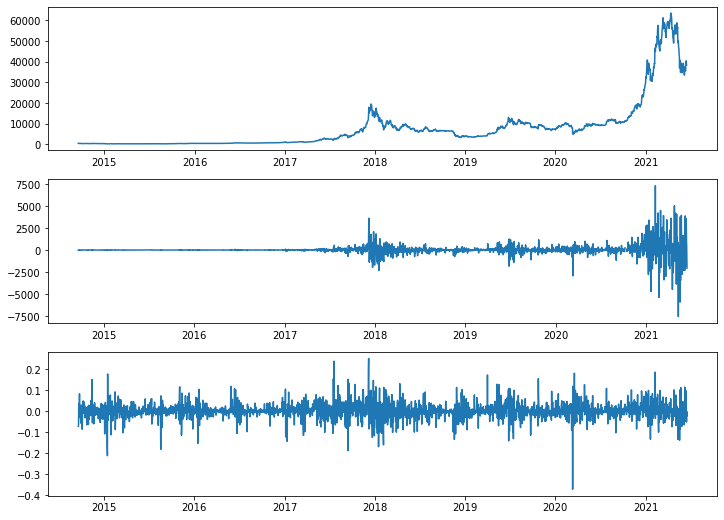

In [139]:
## plotting these
fig, axes = plt.subplots(nrows=3, figsize=(12,9))
axes[0].plot(btc.Close)
axes[1].plot(btc.Close.diff())
axes[2].plot(btc.Close.pct_change())

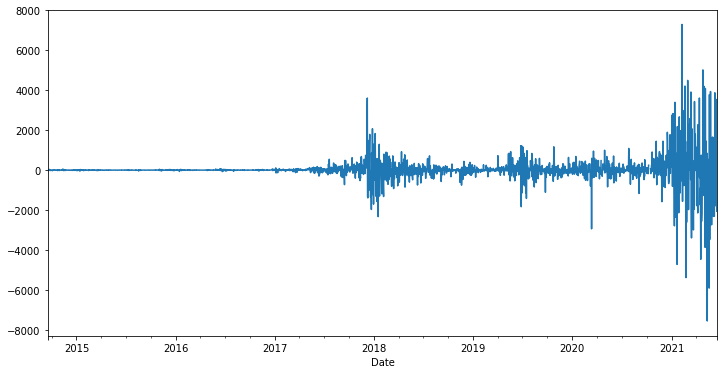

In [140]:
# bigger plot for diff
plt.figure(figsize=(12,6))
btc.Close.diff().plot()
plt.show()

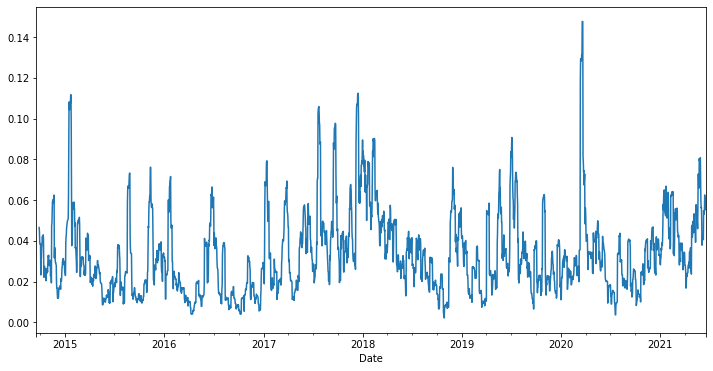

In [141]:
## plotting pct change std at close
plt.figure(figsize=(12,6))
btc.Close.pct_change().rolling(10).std().plot()
plt.show()

In [142]:
## value from previous day
btc['yester_open'] = btc['Open'].shift(1)
btc.head()

,Open,High,Low,Close,Adj Close,Volume,yester_open
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,465.864014
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,456.859985
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,424.102997
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,394.673004


In [143]:
## value from following day
btc['tomorrow_open'] = btc['Open'].shift(-1)
btc.head()

,Open,High,Low,Close,Adj Close,Volume,yester_open,tomorrow_open
Date,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,NaN,456.859985
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,465.864014,424.102997
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,456.859985,394.673004
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,424.102997,408.084991
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,394.673004,399.100006


# BTC predictions

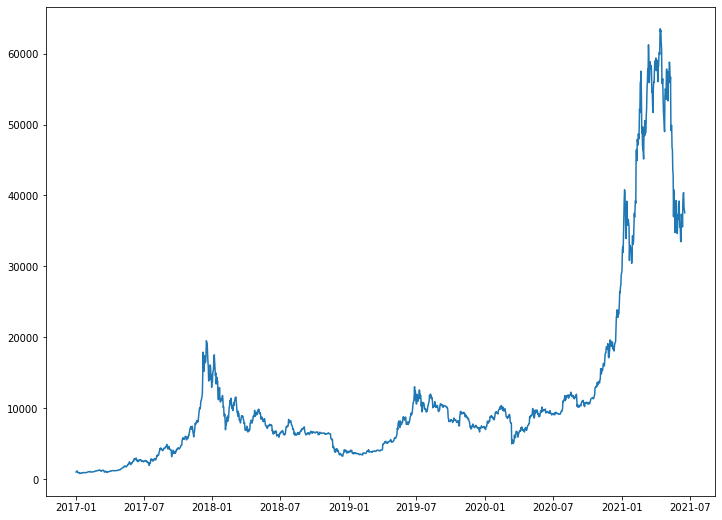

In [159]:
# 1) Selecting only the dates from 2017-01-01 onwards as they are a better representation of current market trends (2017: bitcoin bubble)
btc = btc[['Close']].loc['2017-01-01':]
# visualise the data
plt.figure(figsize=(12,9))
plt.plot(btc['Close'])

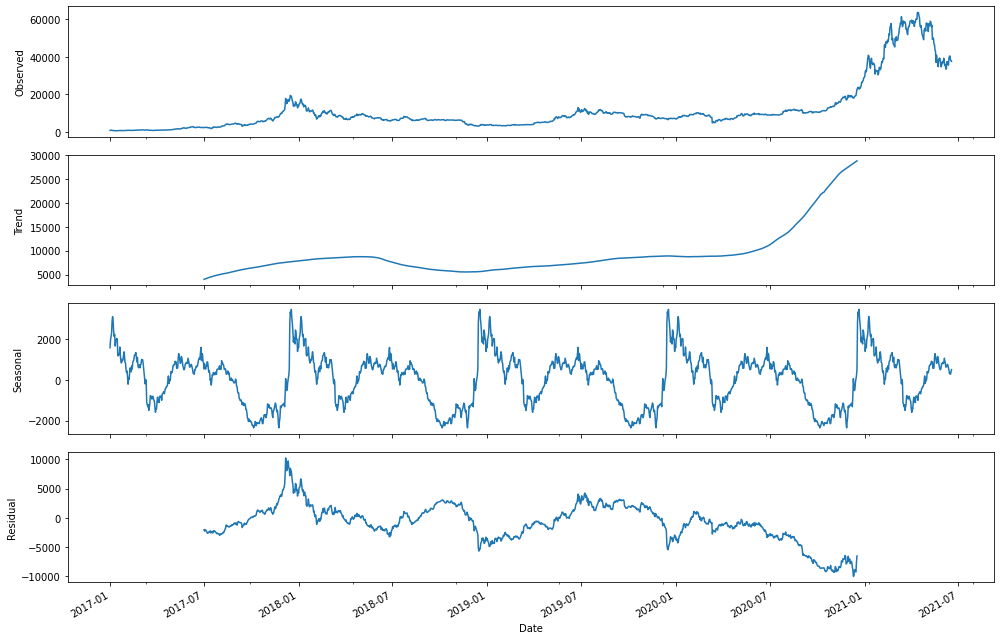

In [160]:
## seasonal decompose
decomp = seasonal_decompose(btc['Close'], model='additive', freq = 365)
plt.rcParams['figure.figsize'] = (14, 9)
decomp.plot();
# 4 seasons

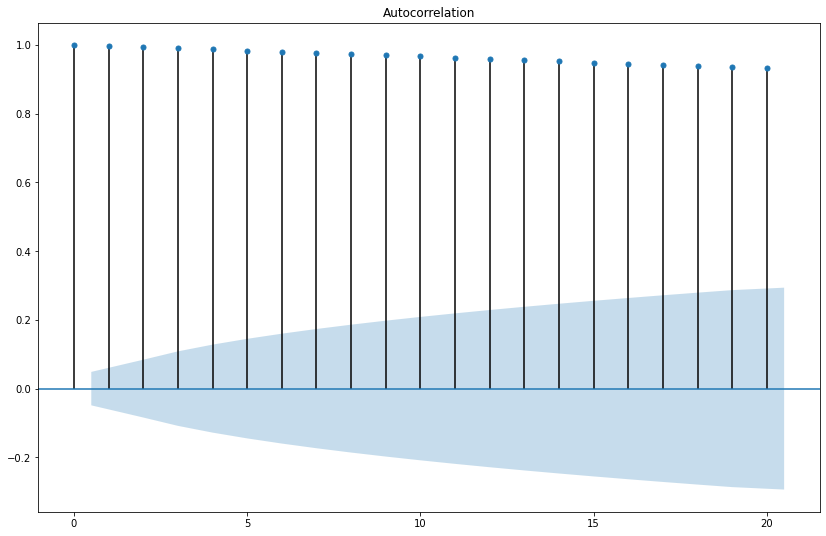

In [161]:
# get ACF to check autocorrelation
plot_acf(btc['Close'], lags = 20); # does not tail off, q = 0

In [ ]:
# get PACF to check partial autocorrelation
plot_pacf(btc['Close'], lags = 20); # tails off, p = 1

In [162]:
# Create Training and Test
test_size = 71
train = btc.Close[:-test_size]
test = btc.Close[-test_size:]

In [163]:
# Build Model and fit on train
model = SARIMAX(train.asfreq('d'), order=(1,1,0), seasonal_order=(1, 1, 0, 4), freq='d')
result= model.fit(disp=0)
# summary stats
result.summary() 
# > p-value < 0.05 goodness of fit 
# > AIC high - model is overfitted 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1558
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 4)   Log Likelihood              -12487.187
Date:                           Thu, 24 Jun 2021   AIC                          24980.373
Time:                                   15:13:15   BIC                          24996.417
Sample:                               01-01-2017   HQIC                         24986.340
                                    - 04-07-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0241      0.011      2.184      0.029       0.002       0.046
ar.S.L4       -0.5177      0.007    -71.102      0.000      -0.532      -0.503
sigma2      5.866e+05   5590.265    104.925      0.000    5.76e+05    5.98e+05
===================================================================================
Ljung-Box (Q):                      526.16   Jarque-Bera (JB):             47702.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.50   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

No handles with labels found to put in legend.


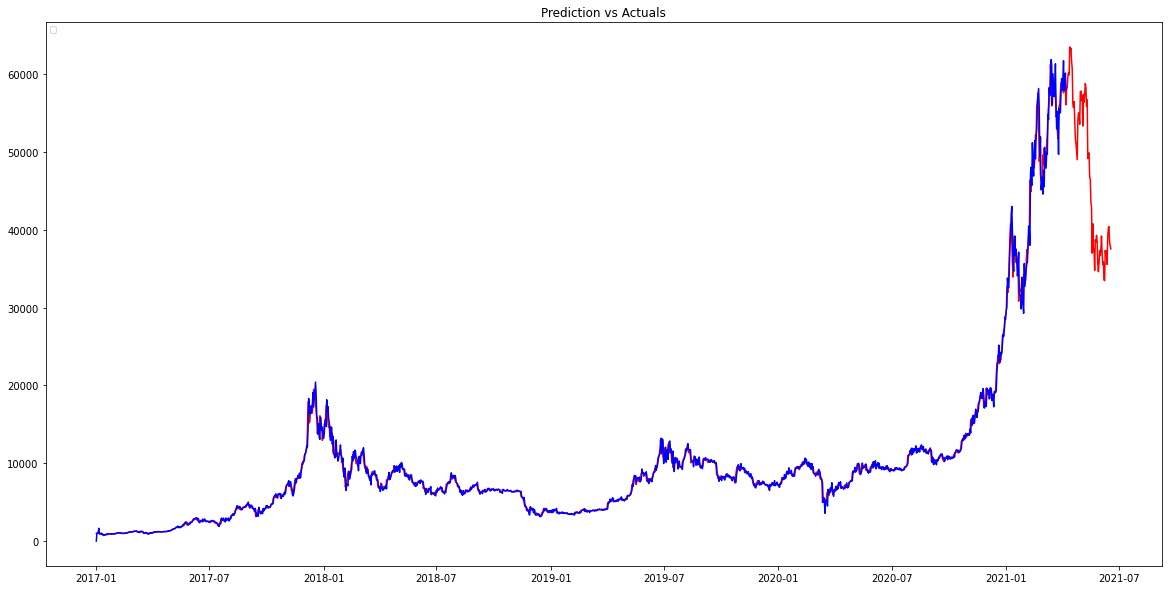

In [164]:
# evaluate performance against train
plt.figure(figsize=(20, 10))
plt.plot(btc['Close'].index, btc['Close'].values, color='red')
plt.plot(result.predict().index, result.predict().values, color='blue')
plt.title('Prediction vs Actuals')

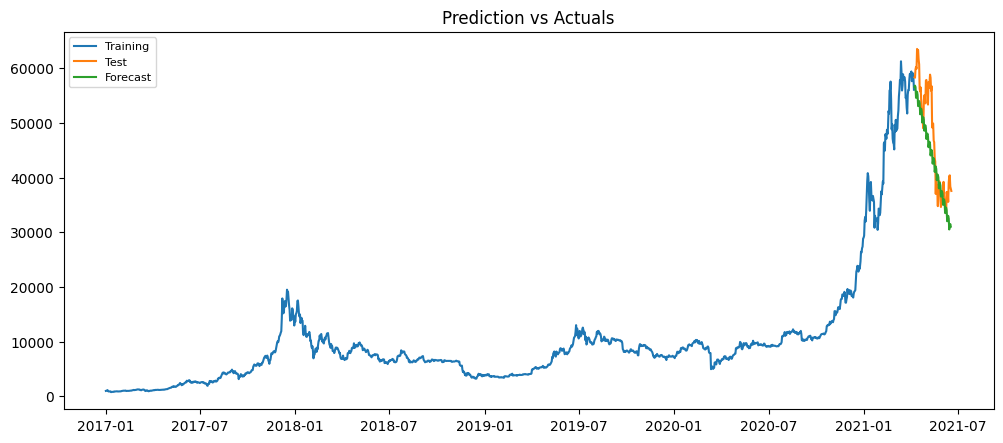

In [165]:
# evaluate performance against test
fc = result.forecast(test_size)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(fc, label='Forecast')
plt.title('Prediction vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
#rmse on test
mse = mean_squared_error(test, fc)
rmse = sqrt(mse)
print('RMSE: %f' % rmse) # high rmse - overfitted model

# Twitter Sentiment Analysis


### Access to Twitter and get tweets from last month

In [168]:
## access to Twitter API
api_key = 'lr6U6qU8hLSkk8mzHiC3zh1PO'
secret = 'ba6i8lQ2VfY4qAaOUYb5BP8vSygWOl5mVpzpmDA92m5w3sEzQ7'

In [ ]:
# get authorization
auth = tw.AppAuthHandler(api_key, secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
## search for tweets containing the term 'bitcoin'
search_term = 'bitcoin lang:en'
## yyyyMMddHHmm
fromDate = '202105170000'
toDate = '202105190000'

In [ ]:
## You will only be able to run this code 48 times this month
## 100 is the max amount of tweets!

tweets = tw.Cursor(api.search_full_archive,
                   environment_name='capstone',
                   query = search_term,
                   fromDate = fromDate,
                   toDate = toDate 

                   ).items(100)


                   ## this gets you the last 100 tweets

In [ ]:
twitter31 = pd.DataFrame(data=[[tweet.text, tweet.created_at] for tweet in tweets])

In [ ]:
twitter31.columns = ['tweet', 'date']

In [ ]:
##to have 100 tweets for each day of the last month
# alternatively, better use pagination (but it wasn't working for me)
twitter.to_csv('bitcoin - Day 1.csv')    # 17/06/2021
twitter2.to_csv('bitcoin - Day 2.csv')   # 16/06/2021
twitter3.to_csv('bitcoin - Day 3.csv')   # 15/06/2021
twitter4.to_csv('bitcoin - Day 4.csv')   # 14/06/2021
twitter5.to_csv('bitcoin - Day 5.csv')   # 13/06/2021
twitter6.to_csv('bitcoin - Day 6.csv')   # 12/06/2021
twitter7.to_csv('bitcoin - Day 7.csv')   # 11/06/2021
twitter8.to_csv('bitcoin - Day 8.csv')   # 10/06/2021
twitter9.to_csv('bitcoin - Day 9.csv')   # 09/06/2021
twitter10.to_csv('bitcoin - Day 10.csv') # 08/06/2021
twitter11.to_csv('bitcoin - Day 11.csv') # 07/06/2021
twitter12.to_csv('bitcoin - Day 12.csv') # 06/06/2021
twitter13.to_csv('bitcoin - Day 13.csv') # 05/06/2021
twitter14.to_csv('bitcoin - Day 14.csv') # 04/06/2021
twitter15.to_csv('bitcoin - Day 15.csv') # 03/06/2021
twitter16.to_csv('bitcoin - Day 16.csv') # 02/06/2021
twitter17.to_csv('bitcoin - Day 17.csv') # 01/06/2021
twitter18.to_csv('bitcoin - Day 18.csv') # 31/05/2021
twitter19.to_csv('bitcoin - Day 19.csv') # 30/05/2021
twitter20.to_csv('bitcoin - Day 20.csv') # 29/05/2021
twitter21.to_csv('bitcoin - Day 21.csv') # 28/05/2021
twitter22.to_csv('bitcoin - Day 22.csv') # 27/05/2021
twitter23.to_csv('bitcoin - Day 23.csv') # 26/05/2021
twitter24.to_csv('bitcoin - Day 24.csv') # 25/05/2021
twitter25.to_csv('bitcoin - Day 25.csv') # 24/05/2021
twitter26.to_csv('bitcoin - Day 26.csv') # 23/05/2021
twitter27.to_csv('bitcoin - Day 27.csv') # 22/05/2021
twitter28.to_csv('bitcoin - Day 28.csv') # 21/05/2021
twitter29.to_csv('bitcoin - Day 29.csv') # 20/05/2021
twitter30.to_csv('bitcoin - Day 30.csv') # 19/05/2021
twitter31.to_csv('bitcoin - Day 31.csv') # 18/05/2021

In [ ]:
# concatenate days together in a complete dataframe
twitter1 = pd.concat([twitter, twitter2, twitter3, twitter4, twitter5, twitter6, twitter7, twitter8, twitter9, twitter10, twitter11, twitter12,
                          twitter13, twitter14, twitter15, twitter16, twitter17, twitter18, twitter19, twitter20, twitter21, twitter22, twitter23,
                          twitter24, twitter25, twitter26, twitter27, twitter28, twitter29, twitter30, twitter31])
twitter1

In [28]:
# twitter1.to_csv('all_bitcoin_tweets.csv') # this was then renamed to 'btc_tweets' to avoid confusion

In [30]:
twitter1 = pd.read_csv('btc_tweets.csv') # containing 100 tweets for each day of the last month 

### Sentiment Analysis in TimeSeries

In [31]:
## sentiment analysis function using SentimentIntensityAnalyzer
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
   
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        return 'positive'
 
    elif sentiment_dict['compound'] <= - 0.05 :
        return 'negative'
 
    else :
        return 'neutral'

In [171]:
# create a 'sentiment' column
twitter1['sentiment'] = twitter1['tweet'].apply(sentiment_scores)

In [172]:
## look at how these mentions change over time --> converting this data to a TimeSeries:

# Convert the 'date' column to np.datetime object
twitter1['date'] = pd.to_datetime(twitter1['date'])

# Set the index of df_tweet to 'date'
twitter1 = twitter1.set_index('date')

twitter1

,tweet,sentiment
date,,
2021-06-16,RT @bulllmarketcoin: BullMarketCoin is Here! O...,positive
2021-06-16,@WSJ For all those who are new to this working...,neutral
2021-06-16,RT @1MillionTokens: 🧐$30 in 12 hours #Giveaway...,neutral
2021-06-16,"RT @BTCTN: ""There's nothing that precludes us ...",positive
2021-06-16,"RT @michael_saylor: On Wednesday, you are all ...",neutral
...,...,...
2021-05-18,RT @SusanStJames3_: Wow! Reports say the pipel...,positive
2021-05-18,"@alljamaals #BTC #Bitcoin\nClear indication, o...",positive
2021-05-18,RT @alexander23: girl r u a bitcoin because i ...,neutral


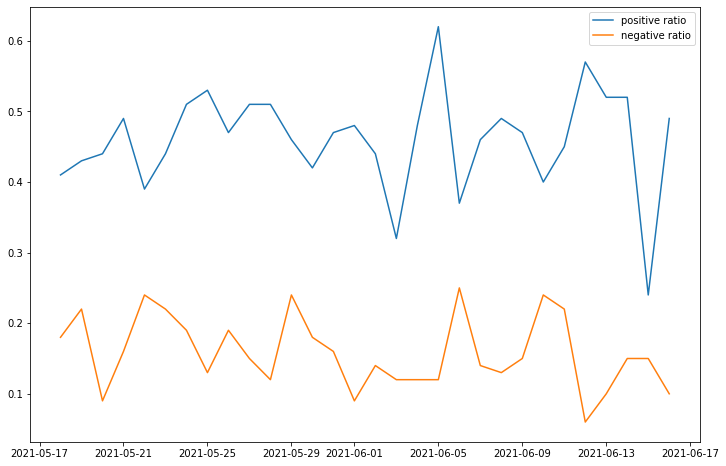

In [173]:
# ratio of positive vs negative tweets in timeseries:
df = twitter1.groupby('date')['sentiment'].value_counts(normalize=True).reset_index(name="ratio") # gets the ratio of positive/negative tweets on each day

positive_ratios = df[df['sentiment'] == 'positive'].sort_values(by='date').set_index('date') # gets just the positive ratio each day
negative_ratios = df[df['sentiment'] == 'negative'].sort_values(by='date').set_index('date') # gets just the negative ratio each day

# plotting the two lines
plt.figure(figsize=(12, 8))
plt.plot(positive_ratios['ratio'], label='positive ratio')
plt.plot(negative_ratios['ratio'], label='negative ratio')
plt.legend()
plt.show()


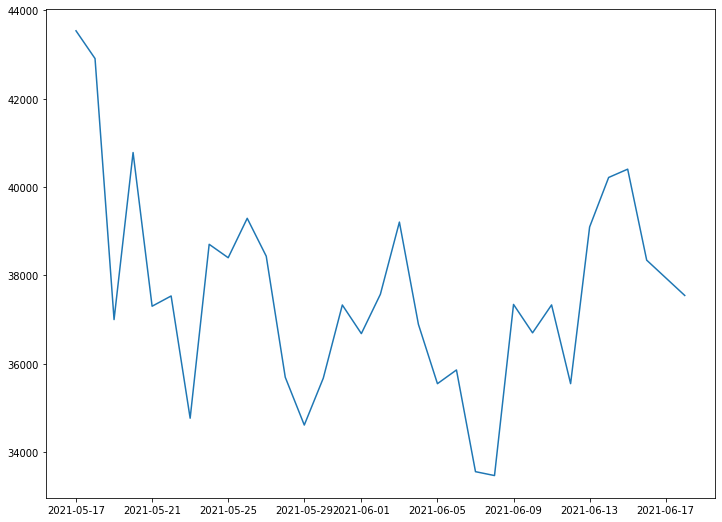

In [174]:
# compare above trends with financial data for the same dates
btc = btc[['Close']].loc['2021-05-17':]
# visualise the data
plt.figure(figsize=(12,9))
plt.plot(btc['Close'])

In [175]:
# use 'positive_ratios' dataframe to forecast bitcoin trends
positive_ratios

,sentiment,ratio
date,,
2021-05-18,positive,0.41
2021-05-19,positive,0.43
2021-05-20,positive,0.44
2021-05-21,positive,0.49
2021-05-22,positive,0.39
2021-05-23,positive,0.44
2021-05-24,positive,0.51
2021-05-25,positive,0.53
2021-05-26,positive,0.47


In [ ]:
# get ACF to check autocorrelation
plot_acf(positive_ratios['ratio'], lags = 20); # q = 0

In [ ]:
# get PACF to check partial autocorrelation
plot_pacf(positive_ratios['ratio'], lags = 20); # p = 0

In [ ]:
# p and q indicate non stationarity

### WordCloud


In [32]:
import os # to interact with the operating system
import itertools # for efficient looping
from collections import Counter # to count elements
import re # to use regular expressions 

## to work with Twitter API
import tweepy as tw

## wordcloud visualisation collection
from wordcloud import WordCloud

## natural language tokens
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

In [3]:
# download built in natural language tokens
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [33]:
# regex clean function
def regex_clean(txt, regex):
    """Replace any text matching the regex

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove matches
    regex : string 
        A text string of the regex pattern you want to match

    Returns
    -------
    The same txt string with the matches removes
    """

    return " ".join(re.sub(regex, "", txt).split())


In [34]:
## create 'cleaned' tweet column
twitter1['cleaned'] = twitter1['tweet'].apply(str.lower)

regex_to_clean = ['(@.+?)\s',
                  '\s\d+\s']

for reg in regex_to_clean:
  twitter1['cleaned'] = twitter1['cleaned'].apply(regex_clean, regex=reg)

In [35]:
## tokenize
twitter1['tokens'] = twitter1['cleaned'].apply(word_tokenize)

In [36]:
## create 'hashtag' column
twitter1['hashtag'] = twitter1['cleaned'].apply(lambda x: re.findall(r"#(\w+)", x))
twitter1['hashtag'] = twitter1['hashtag'].apply(lambda x: [regex_clean(word,r'^([\s\d]+)$') for word in x])

In [37]:
# remove punctuation
punc = '!"#$%&()*+, -./:;<=>?@[\]^_`{|}~'
punc = [x for x in punc]

In [38]:
## import stopwords and add punc
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(['rt', '#', 'fav', '', ':', '@', '!', ';', '…','...', '(', ')', 'https'])
stpwrd.extend(punc)

In [39]:
## apply stopwords to columns
twitter1['tokens'] = twitter1['tokens'].apply(lambda x:[words for words in x if words not in stpwrd])
twitter1['hashtag'] = twitter1['hashtag'].apply(lambda x:[words for words in x if words not in stpwrd])

In [40]:
## look at popular hashtags
hash_tag_counts = Counter()
twitter1['hashtag'].apply(hash_tag_counts.update)
print(hash_tag_counts)

Counter({'bitcoin': 1016, 'crypto': 132, 'cryptocurrency': 95, 'airdrop': 62, 'btc': 60, 'ethereum': 58, 'dogecoin': 51, 'cryptocurrencies': 50, 'blockchain': 45, 'cryptonews': 35, 'cryptotrading': 34, 'bsc': 32, 'trading': 32, 'usd': 30, 'eur': 29, 'cny': 29, 'gbp': 29, 'rub': 29, 'bnb': 25, 'binance': 22, 'giveaway': 18, 'defi': 18, 'ido': 18, 'sto': 17, 'rixx': 16, 'ic': 14, 'safemoon': 13, 'doge': 13, 'coinmarketcap': 12, 'feg': 12, 'bsv': 11, 'altcoin': 10, 'tron': 10, 'cryptocurrencynews': 9, 'eth': 8, 'bitcoinwars': 8, 'cyberattack': 8, 'appsec': 8, 'cybersecurity': 8, 'bitcoincash': 8, 'investing': 7, 'airdrops': 7, 'b': 7, 'hodl': 7, 'cardano': 7, 'altcoins': 7, 'binancesmartchain': 7, 'mastermetals': 7, 'bitcoin2021': 7, 'cash': 6, 'coinbase': 6, 'xrp': 6, 'pancakeswap': 6, 'litecoin': 6, 'gold': 6, 'cryptotwitter': 6, 'ico': 6, 'signals': 5, 'sell': 5, 'btcusd': 5, 'elonmusk': 5, 'buythedip': 5, 'satoshi': 4, 'presale': 4, 'money': 4, 'c': 4, 'trx': 4, 'tokensale': 4, 'elsal

In [41]:
## look at popular tokens
token_counts = Counter()
twitter1['tokens'].apply(token_counts.update)
print(token_counts)

Counter({'bitcoin': 1964, '’': 468, 'crypto': 266, 'airdrop': 242, 'amp': 239, 'btc': 203, "'s": 197, 'new': 189, 'price': 149, 'el': 140, '``': 137, 'cryptocurrency': 133, 'salvador': 129, 'like': 126, 'retweet': 124, 'referral': 124, 'buy': 114, 'one': 111, '🏆': 107, 'reward': 104, '👨\u200d👩\u200d👧': 103, 'follow': 97, "''": 95, '“': 91, 'ethereum': 90, '➕': 86, "n't": 83, 'people': 82, 'first': 81, 'elon': 81, 'task': 77, 'market': 77, '‘': 75, '💧': 75, 'dogecoin': 74, 'would': 73, '”': 72, 'mining': 71, 'project': 69, 'legal': 68, 'join': 68, 'time': 65, 'person': 65, 'live': 64, 'news': 63, 'money': 63, 'giveaway': 62, 'usd': 62, 'start': 62, 'tender': 61, 'cryptocurrencies': 60, '100': 60, '1': 60, 'today': 60, 'airdrop💧': 60, 'make': 59, 'world': 58, 'get': 57, 'blockchain': 57, '🚨': 57, 'go': 56, 'top': 54, 'last': 52, 'going': 52, 'us': 51, 'think': 51, 'inhours': 50, 'finance': 50, 'give': 50, 'day': 50, 'know': 49, 'could': 48, 'total': 48, '🔛': 47, 'tesla': 47, 'million': 4

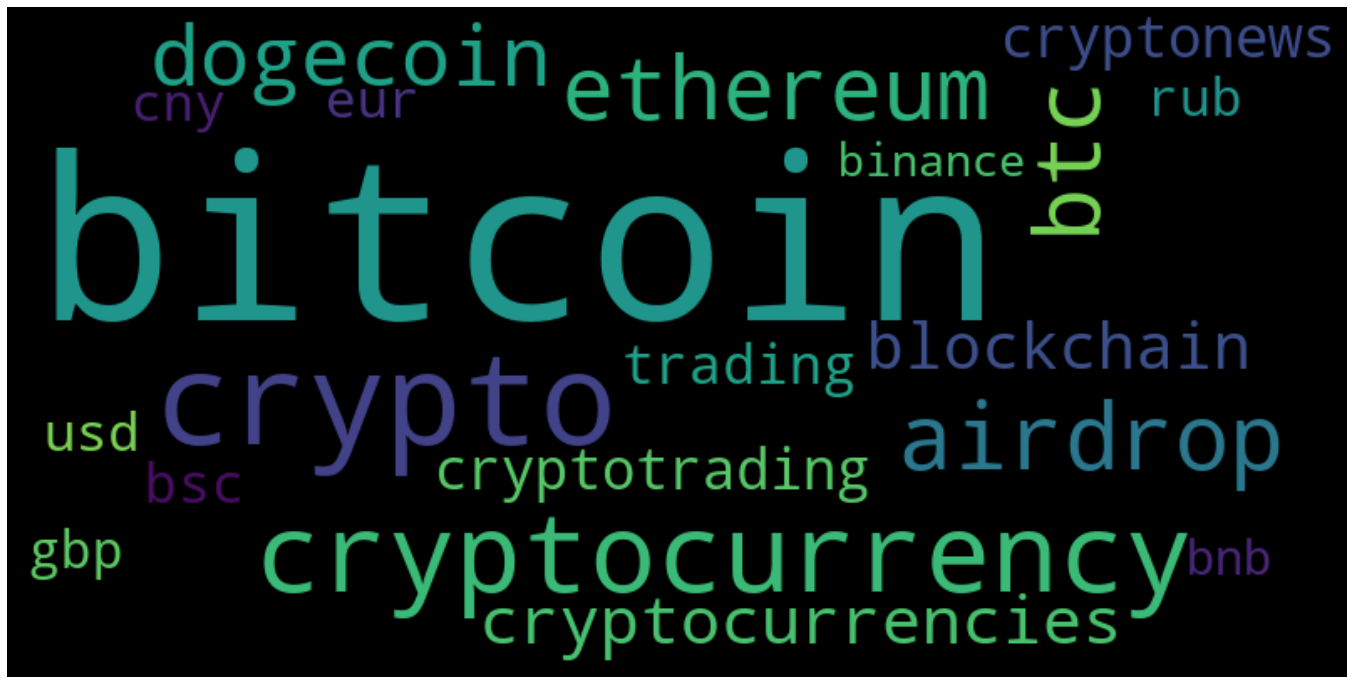

In [42]:
## plot wordcloud for hashtags
wc = WordCloud(width=800, height=400, max_words=20).generate_from_frequencies(hash_tag_counts)
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

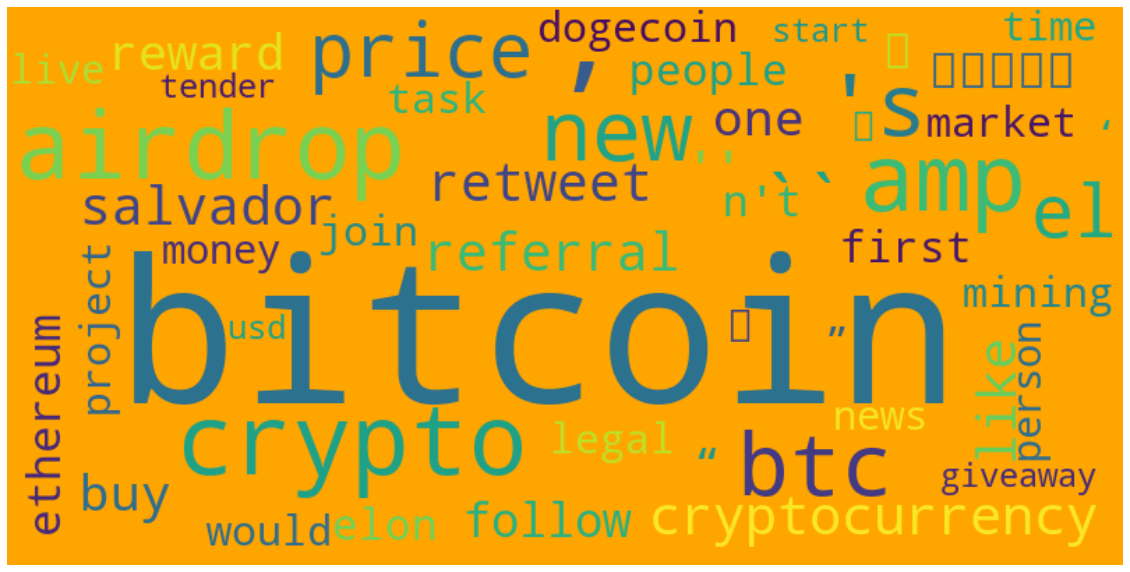

In [209]:
#WordCloud for tokens
wc = WordCloud(background_color= 'orange', width=800, height=400, max_words=50).generate_from_frequencies(token_counts)
plt.figure(figsize=(20,18))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()